# BBLF AI Selector: Part 2: During Tournament Optimal Trades - Model Pipeline

# Prerequistes

In [1]:
# 0. Prerequistes

import pandas as pd
import numpy as np
import math
import os
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import (DecisionTreeRegressor, plot_tree, export_text)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor  
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,root_mean_squared_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.model_selection as skm
from sklearn.model_selection import GridSearchCV 
import joblib

import warnings
warnings.filterwarnings("ignore")

  # Interpret
import interpret
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor

os.getcwd()
directory = 'C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI'
add_data_directory = 'C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI/data/add_data_created/round_9'
over_data_directory = 'C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI/data/add_data_created/overall'
py_data_directory = 'C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI/data/python_datasets'

# Data Extraction

In [2]:
# 1. Data Extraction 
    # Pull in model_data csv file 

model_df = pd.read_csv(os.path.join(py_data_directory,'bblf_during_FS_PowerSurge.csv'), low_memory=False)
print(model_df)

#model_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"] = model_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"].astype(bool)
model_df["Home_f"] = model_df["Home_f"].astype(str)
model_df["Home_f"] = model_df["Home_f"].astype(object)
model_df.loc[:,"opp_Adelaide Strikers":"Home_Hobart Hurricanes"] = model_df.loc[:,"opp_Adelaide Strikers":"Home_Hobart Hurricanes"].astype(object)

model_df_NA_rm = model_df.dropna()
len(model_df_NA_rm)

      Unnamed: 0   match_id         player  season  resp_var  \
0           7396  1226852.0    BAD Manenti      10      41.0   
1           7397  1226852.0   BJ Dwarshuis      10     114.0   
2           7398  1226852.0      CA Ingram      10      75.0   
3           7399  1226852.0  CR Brathwaite      10       6.0   
4           7400  1226852.0      DJM Short      10       3.0   
...          ...        ...            ...     ...       ...   
4776       12172  1386137.0      SA Abbott      13     139.0   
4777       12173  1386137.0     SH Johnson      13     111.0   
4778       12174  1386137.0    SNJ O'Keefe      13      41.0   
4779       12175  1386137.0       T Murphy      13      11.0   
4780       12176  1386137.0    XC Bartlett      13      45.0   

                   team  season_fp_lag1  avg_season_fp_lag1  \
0         Sydney Sixers           202.0           50.500000   
1         Sydney Sixers           715.0           47.666667   
2     Hobart Hurricanes             NaN   

581

# Feature Selection

In [3]:
# 2. Feature Selection
    # Dropping Columns & Create Split Data prior to modelling
col_names = model_df.columns
print (col_names)

other_var_drop = ["resp_var", "Unnamed: 0","season", "player", "team", "match_id","innings"]
feat_drop = ['match_cnt_lag1', 'season_fp_lag2', 'avg_season_fp_lag2','max_season_fp_lag2', 'min_season_fp_lag2', 'med_season_fp_lag2','sd_season_fp_lag2', 'match_cnt_lag2', 'season_fp_lag3','avg_season_fp_lag3', 'max_season_fp_lag3', 'min_season_fp_lag3','med_season_fp_lag3', 'sd_season_fp_lag3', 'match_cnt_lag3',
             'venue_Adelaide Oval', 'venue_GABBA','venue_Hobart', 'venue_Marvel', 'venue_Melbourne Cricket Ground','venue_Other', 'venue_Perth Stadium', 'venue_SCG','venue_Sydney Showground','Home_Adelaide Strikers',
             'Home_Melbourne Stars', 'Home_Melbourne Renegades',
             'Home_Brisbane Heat', 'Home_Perth Scorchers', 'Home_Sydney Sixers',
             'Home_Sydney Thunder', 'Home_Hobart Hurricanes',
             'bat_position_DNB',
             'season_fp_lag1', 'avg_season_fp_lag1', 'max_season_fp_lag1','min_season_fp_lag1', 'med_season_fp_lag1', 'sd_season_fp_lag1',
             #'over_1_f', 'over_2_f', 'over_3_f', 'over_4_f', 'over_5_f', 'over_6_f','over_7_f', 'over_8_f', 'over_9_f', 'over_10_f', 'over_11_f',
             #'over_12_f', 'over_13_f', 'over_14_f', 'over_15_f', 'over_16_f','over_17_f', 'over_18_f', 'over_19_f', 'over_20_f',
             #'bat_position_1.0', 'bat_position_2.0','bat_position_3.0', 'bat_position_4.0', 
             #'over_8_f', 'over_12_f', 'over_10_f', 'over_2_f', 'over_1_f', 'over_5_f',
             'bat_position_5.0', 'bat_position_6.0', 'bat_position_7.0', 'bat_position_8.0','bat_position_9.0', 'bat_position_10.0', 'bat_position_11.0',
             #'curr_seas_min_fp',
             'rank_group_Middle', 'rank_group_High', 'rank_group_Low',
             #'opp_Sydney Sixers', 'opp_Melbourne Stars', 'opp_Melbourne Renegades'              
            ]
#feat_drop = ['match_cnt_lag1', 'season_fp_lag2', 'avg_season_fp_lag2','max_season_fp_lag2', 'min_season_fp_lag2', 'med_season_fp_lag2','sd_season_fp_lag2', 'match_cnt_lag2', 'season_fp_lag3','avg_season_fp_lag3', 'max_season_fp_lag3', 'min_season_fp_lag3','med_season_fp_lag3', 'sd_season_fp_lag3', 'match_cnt_lag3',
#             'bat_position_DNB', 'season_fp_lag1', 'avg_season_fp_lag1', 'max_season_fp_lag1','min_season_fp_lag1', 'med_season_fp_lag1', 'sd_season_fp_lag1']

 #'avg_season_fp_lag1', 'med_season_fp_lag1', 'last_2g_avg_fp','curr_seas_std_fp','opp_Hobart Hurricanes','rank_group_Low', 'min_season_fp_lag1', 'sd_season_fp_lag1', 'opp_Melbourne Renegades', 'opp_Sydney Thunder',
# 'bat_position_11.0', 'opp_Perth Scorchers', 'rank_group_Middle','max_season_fp_lag1', 'curr_seas_avg_fp', 'opp_Perth Scorchers', 'opp_Adelaide Strikers','curr_seas_min_fp', 'opp_Melbourne Stars', 'rank_group_High', 'opp_Brisbane Heat',
# 'opp_Sydney Sixers' 

print(feat_drop)

    # Handling NA values in data
model_df = model_df.drop(feat_drop, axis = 1)    
#model_df.loc[:,"over_1_f":"over_20_f"] = model_df.loc[:,"over_1_f":"over_20_f"].fillna(0)
model_df.loc[:,"over_1_f":"over_20_f"] = model_df.loc[:,"over_1_f":"over_20_f"].fillna(0)
model_df["innings"] = model_df["innings"].fillna(0)
model_df["curr_seas_std_fp"] = model_df["curr_seas_std_fp"].fillna(0)
model_df = model_df.dropna()
len(model_df)

X = model_df.drop(other_var_drop, axis = 1)
#X = X.drop(feat_drop, axis = 1)
Y = model_df["resp_var"]

print(X)
print(Y)

print(X.dtypes)

X_na_rm = model_df_NA_rm.drop(other_var_drop, axis = 1)
X_na_rm = X_na_rm.drop(feat_drop, axis = 1)
Y_na_rm = model_df_NA_rm["resp_var"]


Index(['Unnamed: 0', 'match_id', 'player', 'season', 'resp_var', 'team',
       'season_fp_lag1', 'avg_season_fp_lag1', 'max_season_fp_lag1',
       'min_season_fp_lag1', 'med_season_fp_lag1', 'sd_season_fp_lag1',
       'match_cnt_lag1', 'season_fp_lag2', 'avg_season_fp_lag2',
       'max_season_fp_lag2', 'min_season_fp_lag2', 'med_season_fp_lag2',
       'sd_season_fp_lag2', 'match_cnt_lag2', 'season_fp_lag3',
       'avg_season_fp_lag3', 'max_season_fp_lag3', 'min_season_fp_lag3',
       'med_season_fp_lag3', 'sd_season_fp_lag3', 'match_cnt_lag3', 'Home_f',
       'over_1_f', 'over_2_f', 'over_3_f', 'over_4_f', 'over_5_f', 'over_6_f',
       'over_7_f', 'over_8_f', 'over_9_f', 'over_10_f', 'over_11_f',
       'over_12_f', 'over_13_f', 'over_14_f', 'over_15_f', 'over_16_f',
       'over_17_f', 'over_18_f', 'over_19_f', 'over_20_f', 'innings',
       'prev_game_fp', 'last_2g_avg_fp', 'curr_seas_total_fp',
       'curr_seas_avg_fp', 'curr_seas_max_fp', 'curr_seas_min_fp',
       'curr_

# Train/ Test Split

In [4]:
# 3. Train/ Test Split

seed = 42

np.random.seed(seed)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

names = list(X_train)

X_train_na_rm, X_test_na_rm, Y_train_na_rm, Y_test_na_rm = train_test_split(X_na_rm, Y_na_rm, test_size=0.01, random_state=seed)


# EDA

In [5]:
# EDA 
marginal = Marginal(names).explain_data(X_train_na_rm, Y_train_na_rm, name='Train Data')
show(marginal)



<!-- http://127.0.0.1:7001/1687257522560/ -->

# Model Builder

In [6]:
# 4. Model Build
# 4.0. Model Type Options: a. Linear Regression; b. Decision Tree; c. Random Forest, d. Bagging e. EBM f. GBM

Model_Type = "Random Forest"
print(Model_Type)

# Hyperparameter Grid
param_grid = { 
    'n_estimators': [2000], 
    'max_features': ['sqrt'], 
    'max_depth': [None], 
    #'learning_rate': [0.001, 0.01]
    #'max_leaf_nodes': [5, 10], 
}

Random Forest


In [7]:
# 4a. Linear Regression
if Model_Type == "Linear Regression":
    # Model Object
    model_obj = LinearRegression(fit_intercept = True).fit(X_train_na_rm, Y_train_na_rm)
    #print("Model Coefficients:", model_obj.coef_)
    #print("Model Intercept:", model_obj.coef_)
    X_train_OLS = sm.add_constant(X_train_na_rm).astype(float)
    print(OLS(Y_train,X_train_OLS).fit().summary())

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    #print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    #print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)
    
else:
  print("Note: To create Linear Regression Model change Model Type")

    
# 4b. Decision Tree
if Model_Type == "Decision Tree":
    # Model Object
    model_obj = tree.DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

    # Tree Rules
    rules = tree.export_text(model_obj, feature_names = names)
    print(rules)

    tree.plot_tree(model_obj, feature_names = names, filled = True)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    #print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    #print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)

else:
  print("Note: To create Decision Tree Model change Model Type")

# 4c. Random Forest
if Model_Type == "Random Forest":
    
    # Grid Search
    gs = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, verbose = 3) 
    gs.fit(X_train, Y_train) 
    print(gs.best_estimator_) 
    
    # Model Object     
    model_obj = RandomForestRegressor(n_estimators=gs.best_estimator_.n_estimators,
                                      max_features = gs.best_estimator_.max_features,
                                      max_depth=gs.best_estimator_.max_depth,
                                      #max_leaf_nodes=gs.best_estimator_.max_leaf_nodes,
                                      random_state=0,
                                      oob_score=True).fit(X_train, Y_train)
    print(model_obj.get_params())
  
    #model_obj = RandomForestRegressor(max_features = "sqrt",
    #                                  n_estimators=2000,
    #                                  random_state=0,
    #                                  #max_depth=10,
    #                                  oob_score=True).fit(X_train, Y_train)
    #print(model_obj.get_params())
  
    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    #print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    #print(Y_pred_test)

    # Model Type 
    print(Model_Type)
    
    # Feature List
    print(X_train.columns)
    max_feat = round(math.sqrt(len(X_train.columns)))
    print(max_feat)   

    # feature importance
    feature_imp = pd.DataFrame(
    {'importance':model_obj.feature_importances_},
    index=names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    print(feature_imp)
    
else:
  print("Note: To create Random Forest Model change Model Type")

# 4d. Bagging
if Model_Type == "Bagging":
    # Model Object
    model_obj = RandomForestRegressor(max_features=X_train.shape[1], n_estimators=5000, random_state=0).fit(X_train, Y_train)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    #print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    #print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)
    
    # feature importance
    feature_imp = pd.DataFrame(
    {'importance':model_obj.feature_importances_},
    index=names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    print(feature_imp)

else:
  print("Note: To create Bagging Model change Model Type")

# 4e. EBM
if Model_Type == "EBM":
    # Model Object
    model_obj = ExplainableBoostingRegressor(names, interactions=0).fit(X_train, Y_train)

    # Global Performance
    ebm_global = model_obj.explain_global(name='EBM')
    show(ebm_global)

    # Local Performance
    ebm_local = model_obj.explain_local(X_test, Y_test, name='EBM')
    show(ebm_local, 0)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    #print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    #print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)

else:
  print("Note: To create EBM change Model Type")

# 4f. Boosting
if Model_Type == "GBM":

    # Grid Search
    gs = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid, verbose = 3) 
    gs.fit(X_train, Y_train) 
    print(gs.best_estimator_) 
    
    # Model Object     
    model_obj = GradientBoostingRegressor(n_estimators=gs.best_estimator_.n_estimators,
                                          learning_rate= gs.best_estimator_.learning_rate,
                                          max_depth=gs.best_estimator_.max_depth,
                                          random_state=0).fit(X_train, Y_train)
    print(model_obj.get_params())

    # Model Object
    #model_obj = GradientBoostingRegressor(n_estimators = 5000, learning_rate = 0.001, max_depth = 2, random_state=0).fit(X_train, Y_train)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    #print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    #print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)

    # feature importance
    feature_imp = pd.DataFrame(
    {'importance':model_obj.feature_importances_},
    index=names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    print(feature_imp)

else:
  print("Note: To create GBM change Model Type")

Note: To create Linear Regression Model change Model Type
Note: To create Decision Tree Model change Model Type
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=None, max_features=sqrt, n_estimators=2000;, score=0.073 total time=   9.5s
[CV 2/5] END max_depth=None, max_features=sqrt, n_estimators=2000;, score=0.094 total time=   9.3s
[CV 3/5] END max_depth=None, max_features=sqrt, n_estimators=2000;, score=0.050 total time=   9.2s
[CV 4/5] END max_depth=None, max_features=sqrt, n_estimators=2000;, score=0.028 total time=   9.1s
[CV 5/5] END max_depth=None, max_features=sqrt, n_estimators=2000;, score=0.050 total time=   9.4s
RandomForestRegressor(max_features='sqrt', n_estimators=2000)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monot

MAE - Train: 9.73265554895765
RMSE - Train: 12.258177253899735
R2 - Train: 0.8725090162346031


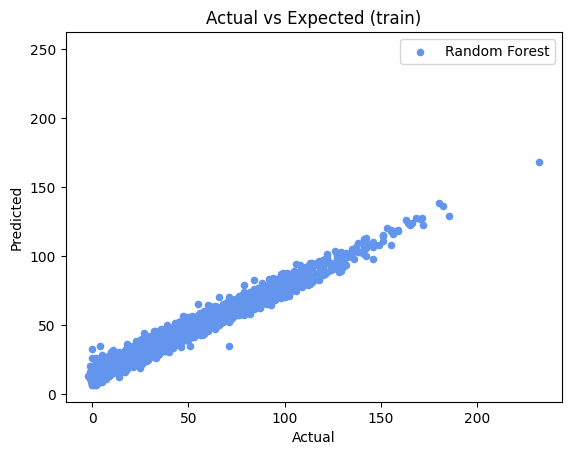

MAE - Test: 25.614937111491308
RMSE - Test: 32.95635715639544
R2 - Test: 0.06924988943684574


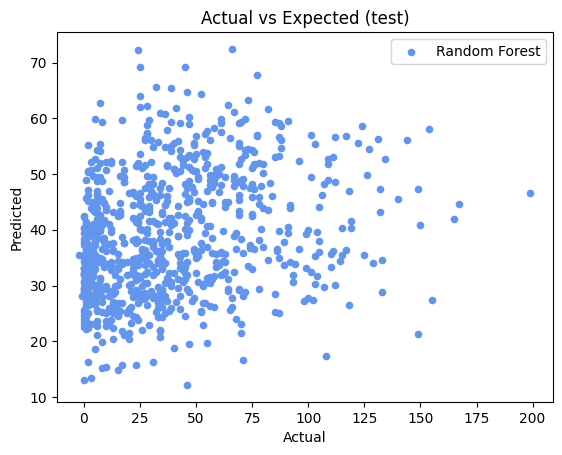

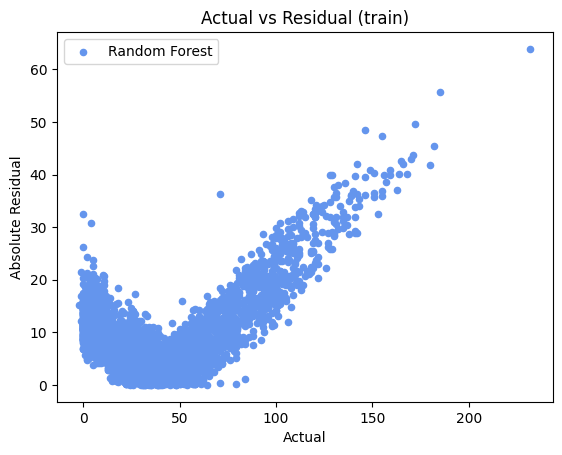

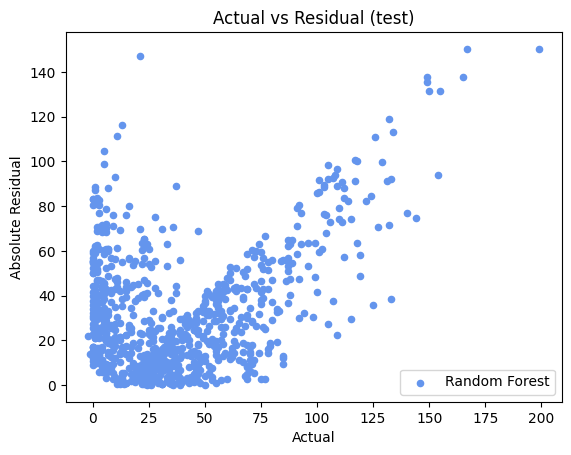

In [8]:
# 5. Model Performance

# 5a. Train Performance Metrics
 
mae_train = mean_absolute_error(y_true = Y_train, y_pred = Y_pred_train)
#mape_train = mean_absolute_percentage_error(y_true = Y_train, y_pred = Y_pred_train) 
rmse_train = root_mean_squared_error(y_true = Y_train, y_pred = Y_pred_train) 
r2_train = r2_score(y_true = Y_train, y_pred = Y_pred_train)

print("MAE - Train:", mae_train) 
#print("MAPE - Train:", mape_train) 
print("RMSE - Train:", rmse_train)
print("R2 - Train:", r2_train)

  # Actual vs Expected Plots

plt.figure()
plt.scatter(Y_train, Y_pred_train, s = 20, color="cornflowerblue", label=Model_Type)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Expected (train)")
plt.plot([0, 0], [250, 250], 'k-')
plt.legend()
plt.show()

# 5b. Test Performance Metrics

mae_test = mean_absolute_error(y_true = Y_test, y_pred = Y_pred_test) 
#mape_test = mean_absolute_percentage_error(y_true = Y_test, y_pred = Y_pred_test) 
rmse_test = root_mean_squared_error(y_true = Y_test, y_pred = Y_pred_test) 
r2_test = r2_score(y_true = Y_test, y_pred = Y_pred_test)

print("MAE - Test:", mae_test)
#print("MAPE - Test:", mape_test)
print("RMSE - Test:", rmse_test)
print("R2 - Test:", r2_test)

  # Actual vs Expected Plots

plt.figure()
plt.scatter(Y_test, Y_pred_test, s = 20, color="cornflowerblue", label= Model_Type)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Expected (test)")
plt.legend()
plt.show()

# 5c. Residual Analysis
  # Train Residuals
Y_train_res = pd.DataFrame(Y_train).reset_index(drop=True)
Y_train_pred = pd.DataFrame(Y_pred_train).reset_index(drop=True)
Y_train_res['pred'] = Y_train_pred[0]
Y_train_res['res'] = Y_train_res['resp_var'] - Y_train_res['pred']
Y_train_res['abs_res'] = abs(Y_train_res['res'])
train_res = pd.concat([Y_train_res, X_train.reset_index(drop=True)], axis=1)

  # Test Residuals
Y_test_res = pd.DataFrame(Y_test).reset_index(drop=True)
Y_test_pred = pd.DataFrame(Y_pred_test).reset_index(drop=True)
Y_test_res['pred'] = Y_test_pred[0]
Y_test_res['res'] = Y_test_res['resp_var'] - Y_train_res['pred']
Y_test_res['abs_res'] = abs(Y_test_res['res'])
test_res = pd.concat([Y_test_res, X_test.reset_index(drop=True)], axis=1)

  # Plots
plt.figure()
plt.scatter(train_res['resp_var'], train_res['abs_res'], s = 20, color="cornflowerblue", label= Model_Type)
plt.xlabel("Actual")
plt.ylabel("Absolute Residual")
plt.title("Actual vs Residual (train)")
plt.legend()
plt.show()


plt.figure()
plt.scatter(test_res['resp_var'], test_res['abs_res'], s = 20, color="cornflowerblue", label= Model_Type)
plt.xlabel("Actual")
plt.ylabel("Absolute Residual")
plt.title("Actual vs Residual (test)")
plt.legend()
plt.show()

# Model Scoring for Current Players

In [9]:
# Save model object
#joblib.dump(model_obj, 'C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI/model/dur_tourny_model_rnd7_19')
model_obj = joblib.load('C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI/model/dur_tourny_model_rnd7_19')
feature_imp = pd.DataFrame(
{'importance':model_obj.feature_importances_},
index=names)
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
print(feature_imp)


                         importance
curr_seas_avg_fp           0.087645
curr_seas_total_fp         0.082235
last_3g_avg_fp             0.081677
last_2g_avg_fp             0.079483
curr_seas_std_fp           0.076416
prev_game_fp               0.075329
curr_seas_max_fp           0.074657
curr_seas_min_fp           0.059243
rank                       0.047091
Home_f                     0.016857
over_20_f                  0.015391
over_19_f                  0.013867
over_17_f                  0.013402
over_4_f                   0.012559
over_13_f                  0.012316
bat_position_1.0           0.011781
over_11_f                  0.011550
opp_Adelaide Strikers      0.011249
opp_Brisbane Heat          0.011199
opp_Sydney Thunder         0.010775
over_18_f                  0.010613
bat_position_3.0           0.010246
opp_Hobart Hurricanes      0.010158
over_15_f                  0.009596
bat_position_4.0           0.009573
over_9_f                   0.009520
opp_Perth Scorchers        0

In [ ]:
# 6. Use Model Object to calculate the number of points for each current player for each gameweek
    # 6a. Data Extraction of BBL 14 Data

# Data Extract to change each round
team_rank_14_df = pd.read_csv(os.path.join(add_data_directory,'team_season_rank_rnd_9.csv'), low_memory=False)
bbl14_prior_df = pd.read_csv(os.path.join(add_data_directory,'player_bbl14_pts_rnd_9.csv'), low_memory=False)
player_over_bowl_df = pd.read_csv(os.path.join(add_data_directory,'player_over_ball_rnd_9.csv'), low_memory=False)
player_bat_pos_df = pd.read_csv(os.path.join(add_data_directory,'player_bat_pos_rnd_9.csv'), low_memory=False)

# BBL 14 Player & their Team Data

player_df = pd.read_csv(os.path.join(py_data_directory,'player_price.csv'), low_memory=False)
player_df = player_df[["Full_Name","player", "Team"]].rename(columns = {"Full_Name":"Name"})
print(player_df)

# BBL 14 Player Features
    # Lags
lags_14_df = pd.read_csv(os.path.join(py_data_directory,'bbl14_lags.csv'), low_memory=False)
lags_14_df = lags_14_df.drop(["Unnamed: 0"], axis = 1)
print(lags_14_df)

# BBL14 Fixture
    ## Need a table of for each team which opposition and where they play against the opposition

team_venue_df = pd.read_csv(os.path.join(over_data_directory,'team_loc_fixture.csv'), low_memory=False)
print(team_venue_df)

## Join BBL14 Player Team Data - All Player Fixture Possible Scenarios
player_fix_scen_df = pd.merge(player_df , team_venue_df, left_on = ["Team"], right_on = ["Team"], how = "left")
player_fix_scen_df = player_fix_scen_df.rename(columns = {"Opposition":"opp", "Venue":"venue"})
print(player_fix_scen_df)

## Join BBL14 Player Feature Data - All Player Fixture Possible Scenarios
bbl14_scen_df = pd.merge(player_fix_scen_df , lags_14_df, left_on = ["player"], right_on = ["player"], how = "left")
print(bbl14_scen_df)

unique_play_fix = player_fix_scen_df['player'].unique()
print(unique_play_fix)

unique_lag = lags_14_df['player'].unique()
print(unique_lag)

# BBL14 Rank Data
team_rank_14_df = team_rank_14_df[team_rank_14_df["season"] == 14].rename(columns = {"team":"opp"})
print(team_rank_14_df)

bbl14_scen_df = pd.merge(bbl14_scen_df , team_rank_14_df, left_on = ["opp"], right_on = ["opp"], how = "left")
bbl14_scen_df['Opposition'] = bbl14_scen_df['opp'].copy()
bbl14_scen_df['Venue'] = bbl14_scen_df['venue'].copy()

# One Hot Encoding
bbl14_play_scen_df = pd.get_dummies(bbl14_scen_df, columns= ['opp','venue','rank_group'])

bbl14_play_scen_df.loc[:,"opp_Adelaide Strikers":"opp_Sydney Thunder"] = bbl14_play_scen_df.loc[:,"opp_Adelaide Strikers":"opp_Sydney Thunder"].astype(int)
bbl14_play_scen_df.loc[:,"opp_Adelaide Strikers":"opp_Sydney Thunder"] = bbl14_play_scen_df.loc[:,"opp_Adelaide Strikers":"opp_Sydney Thunder"].astype(object)

bbl14_play_scen_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"] = bbl14_play_scen_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"].astype(int)
bbl14_play_scen_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"] = bbl14_play_scen_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"].astype(object)

bbl14_play_scen_df.loc[:,"rank_group_High":"rank_group_Middle"] = bbl14_play_scen_df.loc[:,"rank_group_High":"rank_group_Middle"].astype(int)
bbl14_play_scen_df.loc[:,"rank_group_High":"rank_group_Middle"] = bbl14_play_scen_df.loc[:,"rank_group_High":"rank_group_Middle"].astype(object)

# Interaction Terms
# Venue & Home Flag (See if the certain teams have bigger home ground advantage)
bbl14_play_scen_df["Home_Adelaide Strikers"] = np.where((bbl14_play_scen_df["venue_Adelaide Oval"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Melbourne Stars"] = np.where((bbl14_play_scen_df["venue_Melbourne Cricket Ground"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Melbourne Renegades"] = np.where((bbl14_play_scen_df["venue_Marvel"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Brisbane Heat"] = np.where((bbl14_play_scen_df["venue_GABBA"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Perth Scorchers"] = np.where((bbl14_play_scen_df["venue_Perth Stadium"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Sydney Sixers"] = np.where((bbl14_play_scen_df["venue_SCG"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Sydney Thunder"] = np.where((bbl14_play_scen_df["venue_Sydney Showground"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Hobart Hurricanes"] = np.where((bbl14_play_scen_df["venue_Hobart"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)

bbl14_play_scen_df.loc[:,"Home_Adelaide Strikers":"Home_Hobart Hurricanes"] = bbl14_play_scen_df.loc[:,"Home_Adelaide Strikers":"Home_Hobart Hurricanes"].astype(object)

print(bbl14_play_scen_df)

# BBL 14 Prior Tournament Features
    # Data Extract
bbl14_prior_df = bbl14_prior_df.drop(['Team','Price'], axis = 1)
bbl14_prior_df.columns = bbl14_prior_df.columns.str.replace(r'Game_', '')
bbl14_prior_df = pd.melt(bbl14_prior_df, id_vars=['player'], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
                         var_name='Game', value_name='fantasy_point').dropna()

    # Previous Game
bbl14_prev_game_df = bbl14_prior_df[["player", "Game"]].sort_values(by = ['player','Game']).drop_duplicates(subset = ["player"], keep='last')
bbl14_prev_game_df = pd.merge(bbl14_prev_game_df, bbl14_prior_df, left_on = ["player", "Game"], right_on = ["player", "Game"], how = "left" )
bbl14_prev_game_df = bbl14_prev_game_df.rename(columns = {"fantasy_point":"prev_game_fp"})

bbl14_play_scen_df = pd.merge(bbl14_play_scen_df , bbl14_prev_game_df, left_on = ["player"], right_on = ["player"], how = "left")

    # Last 2 Games
bbl14_prev_2g_df = bbl14_prior_df.rename(columns = {"fantasy_point":"last_2g_fp"})
bbl14_prev_2g_df = pd.merge(bbl14_prev_2g_df, bbl14_prev_game_df, left_on = ["player", "Game"], right_on = ["player", "Game"], how = "left")
bbl14_prev_2g_df["drop_col"] = np.where(bbl14_prev_2g_df["prev_game_fp"]>= 0, 1, 0) 
bbl14_prev_2g_df = bbl14_prev_2g_df[bbl14_prev_2g_df.drop_col == 0]
bbl14_prev_2g_df = bbl14_prev_2g_df[["player", "Game"]].sort_values(by = ['player','Game']).drop_duplicates(subset = ["player"], keep='last')
bbl14_prev_2g_df = pd.concat([bbl14_prev_2g_df[["player", "Game"]], bbl14_prev_game_df[["player", "Game"]]])
bbl14_prev_2g_df = pd.merge(bbl14_prev_2g_df, bbl14_prior_df, left_on = ["player", "Game"], right_on = ["player", "Game"], how = "left" )
bbl14_prev_2g_df = bbl14_prev_2g_df.rename(columns = {"fantasy_point":"last_2g_fp"})

bbl14_prev_2g_df_agg = bbl14_prev_2g_df.groupby('player', as_index=False).agg(
last_2g_avg_fp = ('last_2g_fp', "mean"))

bbl14_play_scen_df = pd.merge(bbl14_play_scen_df , bbl14_prev_2g_df_agg, left_on = ["player"], right_on = ["player"], how = "left")

# Last 3 Games
bbl14_prev_3g_df = bbl14_prior_df.rename(columns = {"fantasy_point":"last_3g_fp"})
bbl14_prev_3g_df = pd.merge(bbl14_prev_3g_df, bbl14_prev_2g_df, left_on = ["player", "Game"], right_on = ["player", "Game"], how = "left")
bbl14_prev_3g_df["drop_col"] = np.where(bbl14_prev_3g_df["last_2g_fp"]>= 0, 1, 0) 
bbl14_prev_3g_df = bbl14_prev_3g_df[bbl14_prev_3g_df.drop_col == 0]
bbl14_prev_3g_df = bbl14_prev_3g_df[["player", "Game"]].sort_values(by = ['player','Game']).drop_duplicates(subset = ["player"], keep='last')
bbl14_prev_3g_df = pd.concat([bbl14_prev_3g_df[["player", "Game"]], bbl14_prev_2g_df[["player", "Game"]]])
bbl14_prev_3g_df = pd.merge(bbl14_prev_3g_df, bbl14_prior_df, left_on = ["player", "Game"], right_on = ["player", "Game"], how = "left" )
bbl14_prev_3g_df = bbl14_prev_3g_df.rename(columns = {"fantasy_point":"last_3g_fp"})

bbl14_prev_3g_df_agg = bbl14_prev_3g_df.groupby('player', as_index=False).agg(
last_3g_avg_fp = ('last_3g_fp', "mean"))

bbl14_play_scen_df = pd.merge(bbl14_play_scen_df , bbl14_prev_3g_df_agg, left_on = ["player"], right_on = ["player"], how = "left")

    # Overall Season
bbl14_prior_df_agg = bbl14_prior_df.groupby('player', as_index=False).agg(
curr_seas_total_fp =('fantasy_point',"sum"),
curr_seas_avg_fp = ('fantasy_point', "mean"),
curr_seas_max_fp = ('fantasy_point', 'max'),
curr_seas_min_fp = ('fantasy_point', 'min'),
curr_seas_std_fp = ('fantasy_point', 'std'),
match_cnt = ('fantasy_point', 'count'))

bbl14_play_scen_df = pd.merge(bbl14_play_scen_df , bbl14_prior_df_agg, left_on = ["player"], right_on = ["player"], how = "left")

# Overs Bowled
player_over_bowl_df = player_over_bowl_df.drop(columns= ["Team", "Role", "power_surge_f"], axis = 1)
player_over_bowl_df = pd.merge(player_over_bowl_df, bbl14_prior_df_agg[["player","match_cnt"]], left_on = ["player"], right_on = ["player"])
player_over_bowl_df["match_cnt"] = player_over_bowl_df["match_cnt"].replace(0, 0.01)
player_over_bowl_df.loc[:,"over_1_f":"over_20_f"] = player_over_bowl_df.loc[:,"over_1_f":"over_20_f"].div(player_over_bowl_df['match_cnt'] , axis=0)
player_over_bowl_df = player_over_bowl_df.drop(columns= ["match_cnt"], axis = 1)

bbl14_play_scen_df = pd.merge(bbl14_play_scen_df , player_over_bowl_df, left_on = ["player"], right_on = ["player"], how = "left")

# player_over_bowl_df.loc[:,"over_1_f":"over_20_f"] = player_over_bowl_df.loc[:,"over_flag_1":"over_flag_20"].astype(float)
print(player_over_bowl_df.dtypes)

# Bat Position
player_bat_pos_df = player_bat_pos_df.drop(columns= ["Team", "Role"], axis = 1)
player_bat_pos_df = pd.merge(player_bat_pos_df, bbl14_prior_df_agg[["player","match_cnt"]], left_on = ["player"], right_on = ["player"])
player_bat_pos_df["match_cnt"] = player_bat_pos_df["match_cnt"].replace(0, 0.01)
player_bat_pos_df.loc[:,"bat_position_1.0":"bat_position_DNB"] = player_bat_pos_df.loc[:,"bat_position_1.0":"bat_position_DNB"].div(player_bat_pos_df['match_cnt'] , axis=0)
player_bat_pos_df = player_bat_pos_df.drop(columns= ["match_cnt"], axis = 1)

bbl14_play_scen_df = pd.merge(bbl14_play_scen_df , player_bat_pos_df, left_on = ["player"], right_on = ["player"], how = "left")

# player_over_bowl_df.loc[:,"over_1_f":"over_20_f"] = player_over_bowl_df.loc[:,"over_flag_1":"over_flag_20"].astype(float)
print(player_bat_pos_df.dtypes)

    # 6b. Score Data
# Drop Columns
bbl14_play_scen_df_model_drop = bbl14_play_scen_df.drop(feat_drop, axis = 1)
bbl14_play_scen_df_model = bbl14_play_scen_df_model_drop.drop(["Name", "player", "Team", "season"], axis = 1)

model_col_ord = X_train.columns
bbl14_play_scen_df_model = bbl14_play_scen_df_model[model_col_ord]

# Player Expected Point Scoring
bbl14_play_score = model_obj.predict(bbl14_play_scen_df_model)
print(bbl14_play_score)

bbl14_scen_model_score = bbl14_play_scen_df.copy()
bbl14_scen_model_score["exp_pts"] = bbl14_play_score.copy()
print(bbl14_scen_model_score)

bbl14_scen_model_score.to_csv(os.path.join(py_data_directory,'bbl14_fullteam_model_score_during_rnd_9.csv'))


                Name         player                 Team
0        Sean Abbott      SA Abbott        Sydney Sixers
1        Ashton Agar        AC Agar      Perth Scorchers
2           Wes Agar        WA Agar       Sydney Thunder
3         Finn Allen     Finn Allen      Perth Scorchers
4       Fabian Allen   Fabian Allen    Adelaide Strikers
..               ...            ...                  ...
144        Jon Wells       JW Wells  Melbourne Renegades
145  Jack Wildermuth  JD Wildermuth        Brisbane Heat
146        Jack Wood        JP Wood        Brisbane Heat
147       Mac Wright       M Wright    Hobart Hurricanes
148       Adam Zampa        A Zampa  Melbourne Renegades

[149 rows x 3 columns]
            player        Full_Name  season_fp_lag1  avg_season_fp_lag1  \
0        SA Abbott      Sean Abbott           448.0           49.777778   
1          AC Agar      Ashton Agar           307.0           34.111111   
2          WA Agar         Wes Agar            60.0           15.00